In [118]:
import BioSimSpace as bss
import matplotlib.pyplot as plt
import numpy as np
import scipy
import glob
import BioSimSpace._Exceptions
import pandas as pd
import seaborn as sns
import sklearn.metrics

In [119]:
_K_B = scipy.constants.Boltzmann
_TEMPERATURE = 300
_N_A = scipy.constants.Avogadro


def inhibition_to_ddg(ki_a: float, ki_b: float) -> float:
    """
    convert experimental Ki values to binding free-energy difference
    :param ki_a: experimental Ki of ligand 1
    :param ki_b: experimental Ki of ligand 1
    :return: experimental RBFE value
    """
    ic50_a = 2 * ki_a
    ic50_b = 2 * ki_b
    if ic50_a != 0:
        ddg = (_K_B * _N_A * _TEMPERATURE / 4184) * np.log(ic50_b / ic50_a)
    else:
        ddg = 0
    return ddg

def get_experimental_error(error_a, ki_a, error_b, ki_b):
    if ki_a != 0 and ki_b != 0:
        fraction = ki_b / ki_a
        fraction_error = fraction * np.sqrt((error_b / ki_b) ** 2 + (error_a / ki_a) ** 2)
        return (_K_B * _TEMPERATURE * fraction_error / fraction) * _N_A / 4184
    else:
        return 0

In [120]:
def bootstrap(experimental: np.array, calculated: np.array, n_samples = 10000, alpha_level = 0.05):
    """
    bootstrap pearson's r 
    """
    n_data_samples = len(experimental)
    statistics_dict = {"r": [],
                       "mue": [],
                       "rho": []}

    for i in range(n_samples):
        if i==0:
            experimental_samples = experimental
            calculated_samples = calculated
        else:
            bootstrap_sample = np.random.choice(range(n_data_samples), size = n_samples)
            experimental_samples = [experimental[i] for i in bootstrap_sample]
            calculated_samples = [calculated[i] for i in bootstrap_sample]
        pearson, _ = scipy.stats.pearsonr(experimental_samples, calculated_samples)
        mue = sklearn.metrics.mean_absolute_error(experimental_samples, calculated_samples)
        spearman = scipy.stats.spearmanr(experimental_samples, calculated_samples)
        statistics_dict["r"].append(pearson)
        statistics_dict["mue"].append(mue)
        statistics_dict["rho"].append(spearman)
    results = {"r": {},
               "mue": {},
               "rho": {}}
    lower_fraction = alpha_level/2.0
    upper_fraction = 1 - lower_fraction
    for statistic in statistics_dict.keys():
        results[statistic]["real"] = statistics_dict[statistic][0]
        statistics_dict[statistic] = sorted(statistics_dict[statistic])
        results[statistic]["mean"] = np.mean(statistics_dict[statistic])
        results[statistic]["lower"] = statistics_dict[statistic][int(n_samples * lower_fraction)]
        results[statistic]["upper"] = statistics_dict[statistic][int(n_samples * upper_fraction)]
    return results

In [4]:
# Add simfile header required by biosimspace/pymbar
header_file = "/home/jguven/projects/metalloenzymes/scripts/simfile_header.txt"
with open(header_file, "r") as file:
    header = file.readlines()

somd_path = "/home/jguven/projects/metalloenzymes/azetidinimines/kpc2/outputs/"
paths = sorted(glob.glob(somd_path + "SOMD_*/*/"))
# paths = [somd_path + "lig_1~lig_4/", 
#         # somd_path + "lig_1~lig_5/"
#          ]
for path in paths:

    ligand = path.split("/")[-2]

    free_directory = path + "unbound/"
    bound_directory = path + "bound/"
    print(bound_directory)
    unbound_min_simfiles = sorted(glob.glob(free_directory + "/minimisation/lambda_*/simfile.dat"))

    unbound_simfiles = sorted(glob.glob(free_directory + "lambda_*/simfile.dat"))

    bound_simfiles = sorted(glob.glob(bound_directory + "lambda_*/simfile.dat"))

    for i in range(len(unbound_min_simfiles)):

        with open(unbound_min_simfiles[i], "r") as file:
            min_simfile_lines = file.readlines()

        with open(unbound_min_simfiles[i], "r") as file:
            for j, line in enumerate(file):
                if "lambda" in line:
                    start = j
                if "#" not in line:
                    end = j
                    break

        lambda_header = min_simfile_lines[start:end]
        full_header = header + lambda_header

        with open(unbound_simfiles[i], "r+") as file:
            data = file.readlines()
            file.seek(0, 0)
            header_and_data = full_header + data
            file.writelines(header_and_data)

        with open(bound_simfiles[i], "r+") as file:
            data = file.readlines()
            file.seek(0, 0)
            header_and_data = full_header + data
            file.writelines(header_and_data)

/home/jguven/projects/metalloenzymes/azetidinimines/kpc2/outputs/SOMD_1/lig_7aaa~lig_7aal/bound/
/home/jguven/projects/metalloenzymes/azetidinimines/kpc2/outputs/SOMD_1/lig_7aaa~lig_7aia/bound/
/home/jguven/projects/metalloenzymes/azetidinimines/kpc2/outputs/SOMD_1/lig_7aab~lig_7aea/bound/
/home/jguven/projects/metalloenzymes/azetidinimines/kpc2/outputs/SOMD_1/lig_7aab~lig_7ahb/bound/
/home/jguven/projects/metalloenzymes/azetidinimines/kpc2/outputs/SOMD_1/lig_7aac~lig_7aam/bound/
/home/jguven/projects/metalloenzymes/azetidinimines/kpc2/outputs/SOMD_1/lig_7aac~lig_7dfc/bound/
/home/jguven/projects/metalloenzymes/azetidinimines/kpc2/outputs/SOMD_1/lig_7aad~lig_7aai/bound/
/home/jguven/projects/metalloenzymes/azetidinimines/kpc2/outputs/SOMD_1/lig_7aad~lig_7aaj/bound/
/home/jguven/projects/metalloenzymes/azetidinimines/kpc2/outputs/SOMD_1/lig_7aaf~lig_7aai/bound/
/home/jguven/projects/metalloenzymes/azetidinimines/kpc2/outputs/SOMD_1/lig_7aag~lig_7aaj/bound/
/home/jguven/projects/metalloe

In [38]:
# Write results in analysis files
analysis_file = "somd_results.txt"

somd_paths = sorted(glob.glob("/home/jguven/projects/metalloenzymes/azetidinimines/kpc2/outputs/SOMD_*/"))

for somd_path in somd_paths:
    output_file = somd_path + analysis_file
    paths = sorted(glob.glob(somd_path + "*/"))
    repeat = somd_path.split("/")[-2]
    print(repeat)
    with open(output_file, "w") as file:
        perturbations = []
        for path in paths:
            free_directory = path + "unbound/"
            bound_directory = path + "bound/"
            transformation = path.split("/")[-2]
            file.write(transformation + "\n")
            print(transformation)
            perturbations.append(transformation)
            try:
                pmf_free, overlap_matrix_free = bss.FreeEnergy.Relative.analyse(free_directory)
                pmf_bound, overlap_matrix_bound = bss.FreeEnergy.Relative.analyse(bound_directory)    
                free_energy_difference, free_energy_error = bss.FreeEnergy.Relative.difference(pmf_bound, pmf_free)
                file.write(f"{free_energy_difference} \u00B1 {free_energy_error} \n")    
            except IndexError as e:
                print(str(e)+"\n")
            except ValueError as e:
                print(str(e)+"\n")
            except BioSimSpace._Exceptions.AnalysisError as e:
                print(str(e))


SOMD_1
lig_7aaa~lig_7aal
lig_7aaa~lig_7aia
lig_7aab~lig_7aea
lig_7aab~lig_7ahb
lig_7aac~lig_7aam
lig_7aac~lig_7dfc
lig_7aad~lig_7aai
lig_7aad~lig_7aaj
lig_7aaf~lig_7aai
lig_7aag~lig_7aaj
lig_7aah~lig_7aaj
lig_7aaj~lig_7aak
lig_7aaj~lig_7aam
lig_7aak~lig_7aam
lig_7aba~lig_7aca
lig_7aba~lig_7ada
lig_7aba~lig_7dba
lig_7aba~lig_7dfa
lig_7aba~lig_7fba
lig_7aca~lig_7aea
lig_7ada~lig_7dda
lig_7aea~lig_7dba
lig_7aga~lig_7dga
lig_7aha~lig_7ahb
lig_7aha~lig_7bha
lig_7aha~lig_7cha
lig_7aha~lig_7dha
lig_7ahb~lig_7bhb
lig_7ahb~lig_7dhb
lig_7ahb~lig_7fhb
SOMD free-energy analysis failed!
lig_7bba~lig_7cba
lig_7bba~lig_7dba
lig_7bha~lig_7cha
lig_7bhb~lig_7dhb
lig_7bhb~lig_7fhb
lig_7cba~lig_7cfa
lig_7cba~lig_7dba
lig_7cfa~lig_7dfa
lig_7cha~lig_7dha
lig_7dba~lig_7dda
lig_7dba~lig_7dea
lig_7dba~lig_7dfm
lig_7dea~lig_7dga
lig_7dfa~lig_7dfn
lig_7dfa~lig_7efa
lig_7dfc~lig_7dfm
lig_7dfm~lig_7dfo
lig_7dfn~lig_7dfo
lig_7eba~lig_7efa
lig_7eba~lig_7fba
SOMD_2
lig_7aaa~lig_7aal
lig_7aaa~lig_7aia
lig_7aab~lig_7ae

In [137]:
# Read in results from each repeat
calculated_ddgs = []
calculated_errors = []
analysis_file = "somd_results.txt"
somd_paths = sorted(glob.glob("/home/jguven/projects/metalloenzymes/azetidinimines/kpc2/outputs/SOMD_*/"))
calculated_edges = []
for somd_path in somd_paths:
    input_file = somd_path + analysis_file
    with open(input_file, "r") as file:
        lines = file.readlines()
    edges = [line for line in lines[0:len(lines):2]]
    results = [line for line in lines[1:len(lines):2]]
    ddgs, errors = [], []
    for i in range(len(results)):
        split_results = results[i].split("±")
        try:
            ddgs.append(float(split_results[0].replace("kcal/mol", "").replace("⁻¹ \n", "")))
            errors.append(float(split_results[1].replace("kcal/mol", "").replace("⁻¹ \n", "").replace("kcal mol", "")))
            calculated_edges.append(edges[i])
        except ValueError as e:
            print(f"{e}: There was probably a failed edge above this edge.")
    calculated_ddgs.append(ddgs)
    calculated_errors.append(errors)
calculated_ddgs = np.array(calculated_ddgs).T
calculated_errors = np.array(calculated_errors).T



could not convert string to float: 'lig_7bba~lig_7cba\n': There was probably a failed edge above this edge.
could not convert string to float: 'lig_7bba~lig_7dba\n': There was probably a failed edge above this edge.
could not convert string to float: 'lig_7bha~lig_7cha\n': There was probably a failed edge above this edge.
could not convert string to float: 'lig_7bhb~lig_7dhb\n': There was probably a failed edge above this edge.
could not convert string to float: 'lig_7bhb~lig_7fhb\n': There was probably a failed edge above this edge.
could not convert string to float: 'lig_7cba~lig_7cfa\n': There was probably a failed edge above this edge.
could not convert string to float: 'lig_7cba~lig_7dba\n': There was probably a failed edge above this edge.
could not convert string to float: 'lig_7cfa~lig_7dfa\n': There was probably a failed edge above this edge.
could not convert string to float: 'lig_7cha~lig_7dha\n': There was probably a failed edge above this edge.
could not convert string to 

In [166]:
calculated_edges = []
file = somd_paths[0] + analysis_file
with open(file, "r") as f:
    lines = f.readlines()
edges = [line.strip() for line in lines[0:len(lines):2]]
results = [line for line in lines[1:len(lines):2]]
for i in range(len(results)):
    split = results[i].split("±")
    try:
        test = float(split[0].replace("kcal/mol", "").replace("⁻¹ \n", ""))
        calculated_edges.append(edges[i])
    except ValueError as e:
        print(f"{e}: The edge failed.")
# Get averages accross repeats
calculated_means = np.mean(calculated_ddgs, axis=1)
calculcated_stds = np.std(calculated_ddgs, axis=1)
print(len(calculated_means))

could not convert string to float: 'lig_7bba~lig_7cba\n': The edge failed.
could not convert string to float: 'lig_7bba~lig_7dba\n': The edge failed.
could not convert string to float: 'lig_7bha~lig_7cha\n': The edge failed.
could not convert string to float: 'lig_7bhb~lig_7dhb\n': The edge failed.
could not convert string to float: 'lig_7bhb~lig_7fhb\n': The edge failed.
could not convert string to float: 'lig_7cba~lig_7cfa\n': The edge failed.
could not convert string to float: 'lig_7cba~lig_7dba\n': The edge failed.
could not convert string to float: 'lig_7cfa~lig_7dfa\n': The edge failed.
could not convert string to float: 'lig_7cha~lig_7dha\n': The edge failed.
could not convert string to float: 'lig_7dba~lig_7dda\n': The edge failed.
could not convert string to float: 'lig_7dba~lig_7dea\n': The edge failed.
could not convert string to float: 'lig_7dba~lig_7dfm\n': The edge failed.
could not convert string to float: 'lig_7dea~lig_7dga\n': The edge failed.
could not convert string 

In [166]:
# experimental_data = pd.read_csv("/home/jguven/projects/metalloenzymes/data.csv").drop(index=0).drop(columns={"Unnamed: 2"}).rename(columns={"Unnamed: 0": "Compound",
#                                                                                                                                             "KPC-2": "K_i",
#                                                                                                                                             "Unnamed: 3": "error"})
experimental_data = pd.read_csv("/home/jguven/projects/metalloenzymes/azetidinimines/kpc2/afe/exp_data_with_errors.csv", header=0)
clean_experimental_data = experimental_data[["Compound", "K_i", "err."]]
# print(clean_experimental_data.head())
compounds = clean_experimental_data["Compound"].tolist()
kis = clean_experimental_data["K_i"].tolist()
errors = clean_experimental_data["error"].tolist()


In [167]:
experimental_dict = {compounds[i]: [kis[i], errors[i]] for i in range(len(compounds))}
print(experimental_dict)

{'7aac': [1.15, 0.1615], '7aaj': [2.41, 0.0542], '7aea': [0.73, 0.3609], '7bba': [1.93, 0.1542], '7cba': [1.55, 0.2949], '7eba': [2.36, 0.6391], '7efa': [6.04, 0.273], '7bha': [3.94, 0.1341], '7cha': [5.23, 0.1418], '7dha': [1.6, 0.1022], '7bhb': [1.96, 0.2237], '7dhb': [1.84, 0.305], '7fhb': [1.81, 0.0931], '7dda': [6.49, 0.2062], '7dea': [5.66, 0.1271], '7dfc': [3.69, 0.3262], '7dfm': [0.28, 0.4241], '7dfn': [3.89, 0.1326], '7dfo': [4.15, 0.2093]}


ERROR! Session/line number was not unique in database. History logging moved to new session 215


In [175]:
for i in compounds:
    print(i)

7aac
7aaj
7aea
7bba
7cba
7eba
7efa
7bha
7cha
7dha
7bhb
7dhb
7fhb
7dda
7dea
7dha
7dfc
7dfm
7dfn
7dfo


In [174]:
# # Get ligand indices for getting the correct experimental values
first_compounds = []
second_compounds = []

cleaned_edges = []
# Credit: Jonathan Coldstream (I didn't think it was gonna work)
for i in range(len(calculated_edges)):
    line = calculated_edges[i]
    lig_1 = line.split("~")[0].replace("lig_", "")
    lig_2 = line.split("~")[1].replace("lig_", "")
    print(lig_1, lig_2)
    keep = False

    if lig_1 in compounds and lig_2 in compounds:
        keep = True
    if keep == True:
        cleaned_edges.append(calculated_edges[i])

print(cleaned_edges)

7aaa 7aal
7aaa 7aia
7aab 7aea
7aab 7ahb
7aac 7aam
7aac 7dfc
7aad 7aai
7aad 7aaj
7aaf 7aai
7aag 7aaj
7aah 7aaj
7aaj 7aak
7aaj 7aam
7aak 7aam
7aba 7aca
7aba 7ada
7aba 7dba
7aba 7dfa
7aba 7fba
7aca 7aea
7ada 7dda
7aea 7dba
7aga 7dga
7aha 7ahb
7aha 7bha
7aha 7cha
7aha 7dha
7ahb 7bhb
7ahb 7dhb
['lig_7aac~lig_7dfc']


In [164]:
first_compounds, second_compounds = [], []
for line in calculated_edges:
    lig_1 = line.split("~")[0].replace("lig_", "")
    lig_2 = line.split("~")[1].replace("lig_", "")
    first_compounds.append(lig_1)
    second_compounds.append(lig_2)

for i in range(len(first_compounds)):
    print(first_compounds[i], second_compounds[i])


7aaa 7aal
7aaa 7aia
7aab 7aea
7aab 7ahb
7aac 7aam
7aac 7dfc
7aad 7aai
7aad 7aaj
7aaf 7aai
7aag 7aaj
7aah 7aaj
7aaj 7aak
7aaj 7aam
7aak 7aam
7aba 7aca
7aba 7ada
7aba 7dba
7aba 7dfa
7aba 7fba
7aca 7aea
7ada 7dda
7aea 7dba
7aga 7dga
7aha 7ahb
7aha 7bha
7aha 7cha
7aha 7dha
7ahb 7bhb
7ahb 7dhb


In [165]:

experimental_free_energies = []
experimental_errors = []

for i in range(len(first_compounds)):
    key_1, key_2 = first_compounds[i], second_compounds[i]
    print(f"lig 1: {key_1}, lig_2: {key_2}")
    try:
        ki_a, ki_b = experimental_dict[key_1][0], experimental_dict[key_2][0]
        experimental_free_energy = inhibition_to_ddg(float(ki_a), float(ki_b))
        err_a, err_b = experimental_dict[key_1][1], experimental_dict[key_2][1]
        experimental_error = get_experimental_error(float(err_a), float(ki_a), float(err_b), float(ki_b))
        experimental_free_energies.append(experimental_free_energy)
        experimental_errors.append(experimental_error)
    except KeyError as e:
        print(f"{e}: The compound {key_1} or {key_2} have multiple values. ")


lig 1: 7aaa, lig_2: 7aal
'7aaa': The compound 7aaa or 7aal have multiple values. 
lig 1: 7aaa, lig_2: 7aia
'7aaa': The compound 7aaa or 7aia have multiple values. 
lig 1: 7aab, lig_2: 7aea
'7aab': The compound 7aab or 7aea have multiple values. 
lig 1: 7aab, lig_2: 7ahb
'7aab': The compound 7aab or 7ahb have multiple values. 
lig 1: 7aac, lig_2: 7aam
'7aam': The compound 7aac or 7aam have multiple values. 
lig 1: 7aac, lig_2: 7dfc
lig 1: 7aad, lig_2: 7aai
'7aad': The compound 7aad or 7aai have multiple values. 
lig 1: 7aad, lig_2: 7aaj
'7aad': The compound 7aad or 7aaj have multiple values. 
lig 1: 7aaf, lig_2: 7aai
'7aaf': The compound 7aaf or 7aai have multiple values. 
lig 1: 7aag, lig_2: 7aaj
'7aag': The compound 7aag or 7aaj have multiple values. 
lig 1: 7aah, lig_2: 7aaj
'7aah': The compound 7aah or 7aaj have multiple values. 
lig 1: 7aaj, lig_2: 7aak
'7aak': The compound 7aaj or 7aak have multiple values. 
lig 1: 7aaj, lig_2: 7aam
'7aam': The compound 7aaj or 7aam have multiple 

In [113]:
len(experimental_errors)

22

In [127]:
labels = [string.replace("lig_", "").replace("~"," to ") for string in cleaned_edges]
len(labels)

42

In [128]:
for label in labels:
    print(label)

7aaa to 7aia
7aab to 7aea
7aab to 7ahb
7aac to 7dfc
7aad to 7aai
7aad to 7aaj
7aaf to 7aai
7aag to 7aaj
7aah to 7aaj
7aaj to 7aak
7aba to 7aca
7aba to 7ada
7aba to 7dba
7aba to 7dfa
7aba to 7fba
7aca to 7aea
7ada to 7dda
7aea to 7dba
7aha to 7ahb
7aha to 7bha
7aha to 7cha
7aha to 7dha
7ahb to 7bhb
7ahb to 7dhb
7ahb to 7fhb
7bba to 7cba
7bba to 7dba
7bha to 7cha
7bhb to 7dhb
7bhb to 7fhb
7cba to 7dba
7cha to 7dha
7dba to 7dda
7dba to 7dea
7dba to 7dfm
7dfa to 7dfn
7dfa to 7efa
7dfc to 7dfm
7dfm to 7dfo
7dfn to 7dfo
7eba to 7efa
7eba to 7fba


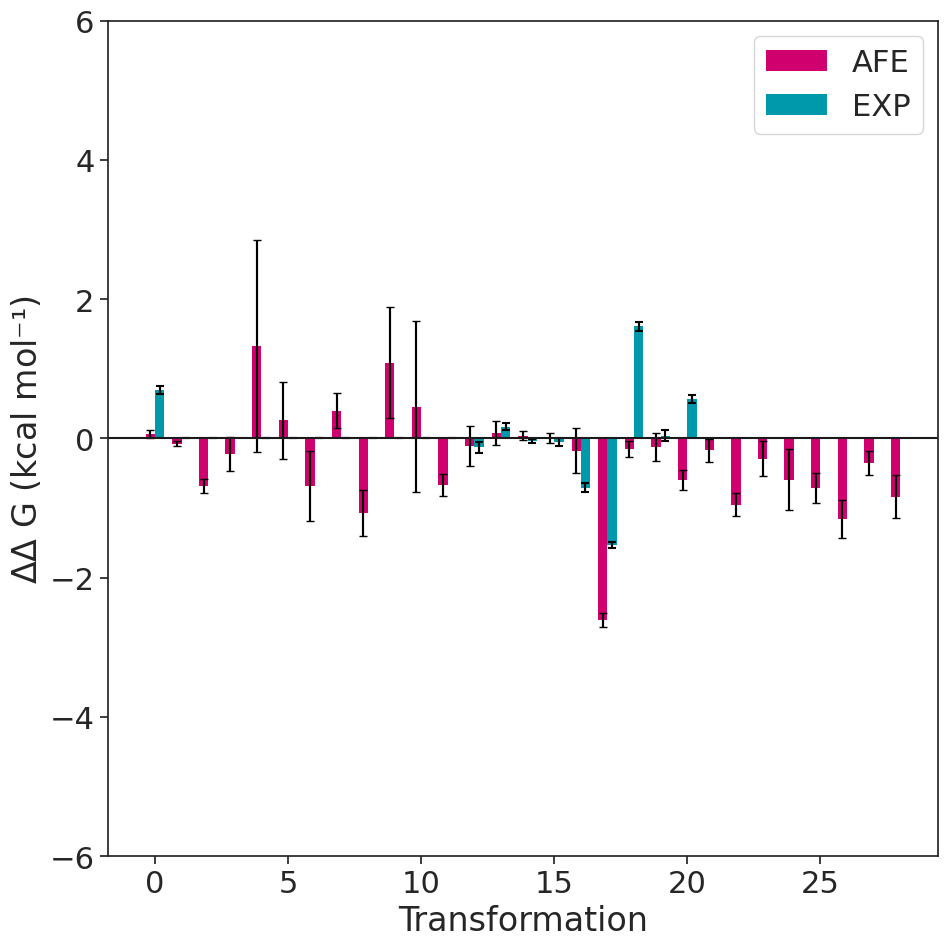

In [117]:
fig = plt.figure(figsize=(10, 10))
sns.set(context="notebook", palette="colorblind", style="ticks", font_scale=2)
x_label_locations = np.arange(len(calculated_means))
bar_width = 0.35

plt.bar(x_label_locations - bar_width / 2,
        height=calculated_means,
        width=bar_width,
        yerr=calculcated_stds,
        label="AFE",
        color="#D0006F",
        linewidth=0)

(_, caps, _) = plt.errorbar(x_label_locations - bar_width / 2,
                            calculated_means,
                            color="black",
                            yerr=calculcated_stds,
                            capsize=3,
                            linestyle="")

x_label_locations = np.arange(len(experimental_free_energies))
bar_width = 0.35

plt.bar(x_label_locations + bar_width / 2,
        height=experimental_free_energies,
        width=bar_width,
        yerr=experimental_errors,
        label="EXP",
        color="#0099AB",
        linewidth=0)

(_, caps, _) = plt.errorbar(x_label_locations + bar_width / 2,
                            experimental_free_energies,
                            color="black",
                            yerr=experimental_errors,
                            capsize=3,
                            linestyle="")

for cap in caps:
    cap.set_color("black")
    cap.set_markeredgewidth(1.5)
# plt.ylim(-55, -40)
plt.axhline(0, 0, 1, c="k")
plt.ylim(-6, 6)
# plt.xticks(x_label_locations - bar_width / 2, labels, rotation=85, ha="center")
plt.legend()
plt.xlabel("Transformation")
plt.ylabel("$\Delta \Delta$ G (kcal mol⁻¹)")
plt.tight_layout()
plt.savefig("ddg.png", dpi=1200, transparent=True)


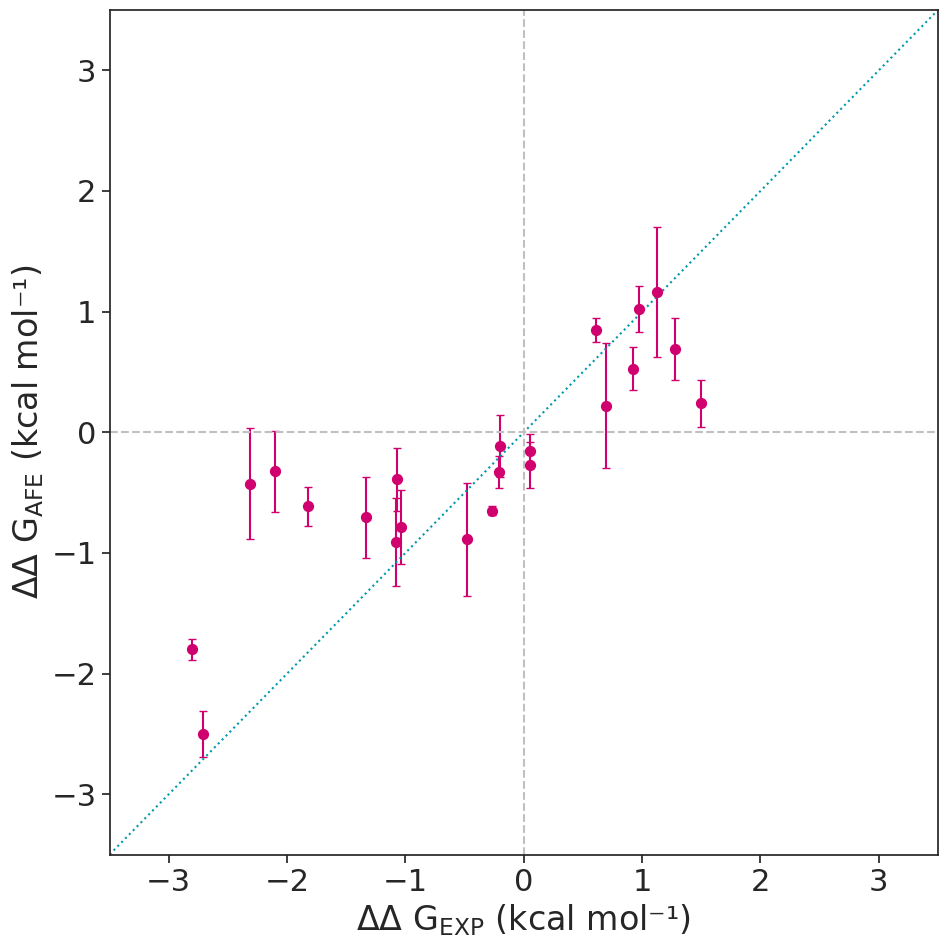

In [11]:
plt.figure(figsize=(10, 10))
sns.set(context="notebook", palette="colorblind", style="ticks", font_scale=2)
plt.scatter(experimental_free_energies, calculated_means, s=50, color="#D0006F")
# plt.scatter(3, 2.5, s=0)

(_, caps, _) = plt.errorbar(experimental_free_energies,
                           calculated_means,
                           color="#D0006F",
                           yerr=calculcated_stds,
                           capsize=3,
                           linestyle="",
                           zorder=-1)

plt.plot([-4.5, 4.5], [-4.5, 4.5], color="#0099AB", linestyle=":", zorder=-1)
plt.xlabel("$\Delta \Delta$ G$_\mathrm{EXP}$ (kcal mol⁻¹)")
plt.ylabel("$\Delta \Delta$ G$_\mathrm{AFE}$ (kcal mol⁻¹)")
plt.vlines(0, -3.5, 3.5, color = "silver", linestyle="--", zorder=-1)
plt.hlines(0, -3.5, 3.5, color = "silver", linestyle="--", zorder=-1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.tight_layout()
plt.savefig("corr.png", dpi=1200, transparent=True)

In [42]:
pearson_r = scipy.stats.pearsonr(experimental_free_energies, calculated_means)
pearson_r

PearsonRResult(statistic=0.8361613217258689, pvalue=1.2555500864017351e-06)

In [43]:
spearman = scipy.stats.spearmanr(experimental_free_energies, calculated_means)
spearman

SignificanceResult(statistic=0.8531902879728968, pvalue=4.5142615003636913e-07)

In [48]:
mue = sklearn.metrics.mean_absolute_error(experimental_free_energies, calculated_means)
mue

0.5633331683181537

In [17]:
stats = bootstrap(experimental_free_energies, calculated_means)
stats

{'r': {'real': 0.8361613217258689,
  'mean': 0.8361611548984885,
  'lower': 0.8309844573064162,
  'upper': 0.8414127202171514},
 'mue': {'real': 0.5633331683181537,
  'mean': 0.5634106071907505,
  'lower': 0.5532072552745424,
  'upper': 0.573766438050529},
 'rho': {'real': SignificanceResult(statistic=0.8531902879728968, pvalue=4.5142615003636913e-07),
  'mean': 0.42659142874503925,
  'lower': SignificanceResult(statistic=0.8465951261424967, pvalue=0.0),
  'upper': SignificanceResult(statistic=0.8595613106099496, pvalue=0.0)}}